In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['18GU','total'])
    lista_ine2.append(ine_ods[date].loc['013B','total'])
    lista_ine3.append(ine_ods[date].loc['021S','total'])
    lista_ine4.append(ine_ods[date].loc['219M','total'])
    lista_ine5.append(ine_ods[date].loc['01CA','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,3314
2020-04-02,3220
2020-04-03,3934
2020-04-04,3141
2020-04-05,2520


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,4188.802469
std,922.684743
min,2282.000000
25%,3503.000000
50%,4243.000000
75%,4933.000000
max,5827.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,3410.966667
2020-05-31,4262.193548
2020-06-30,5241.800000


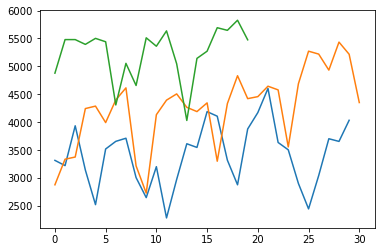

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
dataset = df.values
dataset = dataset.astype('float32')

In [16]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [20]:
print(trainX)

[[0.29111427 0.26459807 0.46600848 0.24231315 0.06713682 0.3486601
  0.38730603]
 [0.26459807 0.46600848 0.24231315 0.06713682 0.3486601  0.38730603
  0.40310293]
 [0.46600848 0.24231315 0.06713682 0.3486601  0.38730603 0.40310293
  0.20394921]
 [0.24231315 0.06713682 0.3486601  0.38730603 0.40310293 0.20394921
  0.10267985]
 [0.06713682 0.3486601  0.38730603 0.40310293 0.20394921 0.10267985
  0.25923836]
 [0.3486601  0.38730603 0.40310293 0.20394921 0.10267985 0.25923836
  0.        ]
 [0.38730603 0.40310293 0.20394921 0.10267985 0.25923836 0.
  0.19464034]
 [0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
  0.37517637]
 [0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
  0.3565585 ]
 [0.10267985 0.25923836 0.         0.19464034 0.37517637 0.3565585
  0.53765875]
 [0.25923836 0.         0.19464034 0.37517637 0.3565585  0.53765875
  0.5145275 ]
 [0.         0.19464034 0.37517637 0.3565585  0.53765875 0.5145275
  0.29196054]
 [0.19464034 0.37517637 0.3

In [21]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
print(trainX)

[[[0.29111427]
  [0.26459807]
  [0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]]

 [[0.26459807]
  [0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]]

 [[0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]]

 [[0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]]

 [[0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]]

 [[0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]]

 [[0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]]

 [[0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]
  [0.37517637]]

 [[0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]
  [0.37517637]
  [0.3565585 ]]

 [[0.10267985]
  [0.25923836]
  [0.  

In [23]:
print(trainY)

[0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
 0.37517637 0.3565585  0.53765875 0.5145275  0.29196054 0.16755998
 0.44992954 0.5328632  0.65500706 0.38166434 0.34442878 0.17433006
 0.04569817 0.21438646 0.40056425 0.387024   0.49393517 0.16755998
 0.29703808 0.3080395  0.5531735  0.5655853  0.4823696  0.59689707
 0.6578279  0.2631876  0.12552893 0.5221439  0.59576875 0.62736255
 0.5593794  0.5379408  0.58194643 0.28688294 0.57856137 0.719323
 0.60338503 0.61354023 0.6662906  0.64767283 0.3590973  0.6787024
 0.84344155 0.82877296 0.7478139  0.88942176 0.8279267 ]


# Creamos la red neuronal

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [25]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0246 - val_loss: 0.0344
Epoch 124/200
53/53 - 0s - loss: 0.0228 - val_loss: 0.0207
Epoch 125/200
53/53 - 0s - loss: 0.0251 - val_loss: 0.0227
Epoch 126/200
53/53 - 0s - loss: 0.0259 - val_loss: 0.0209
Epoch 127/200
53/53 - 0s - loss: 0.0246 - val_loss: 0.0286
Epoch 128/200
53/53 - 0s - loss: 0.0270 - val_loss: 0.0220
Epoch 129/200
53/53 - 0s - loss: 0.0258 - val_loss: 0.0237
Epoch 130/200
53/53 - 0s - loss: 0.0262 - val_loss: 0.0228
Epoch 131/200
53/53 - 0s - loss: 0.0242 - val_loss: 0.0195
Epoch 132/200
53/53 - 0s - loss: 0.0248 - val_loss: 0.0221
Epoch 133/200
53/53 - 0s - loss: 0.0252 - val_loss: 0.0263
Epoch 134/200
53/53 - 0s - loss: 0.0247 - val_loss: 0.0223
Epoch 135/200
53/53 - 0s - loss: 0.0238 - val_loss: 0.0201
Epoch 136/200
53/53 - 0s - loss: 0.0278 - val_loss: 0.0193
Epoch 137/200
53/53 - 0s - loss: 0.0250 - val_loss: 0.0194
Epoch 138/200
53/53 - 0s - loss: 0.0232 - val_loss: 0.0216
Epoch 139/200
53/53 - 0s - loss: 0.0266 - val_loss: 0.02

# Visualizamos resultados

In [26]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [27]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [28]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 359.69 MAE
Resultado del entrenamiento: 197273.96 MSE
Resultado del entrenamiento: 444.16 RMSE
Resultado del entrenamiento: 11.38 CVRMSE
Resultado del entrenamiento: 10.13 MAPE 

Resultado del test: 441.48 MAE
Resultado del test: 370121.05 MSE
Resultado del test: 608.38 RMSE
Resultado del test: 11.72 CVRMSE
Resultado del test: 9.47 MAPE


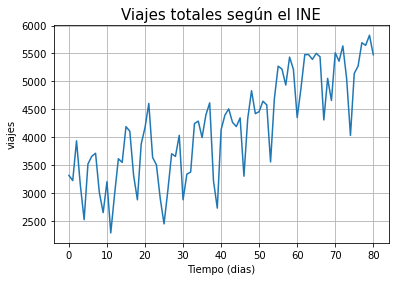

In [29]:
plt.plot(df.values)
plt.grid(True)
plt.title("Viajes totales según el INE", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

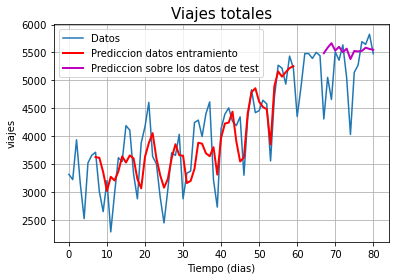

In [30]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

In [31]:
results=testPredict
print(len(results))

14


In [32]:
testResults = testY_scalerInverse[0]

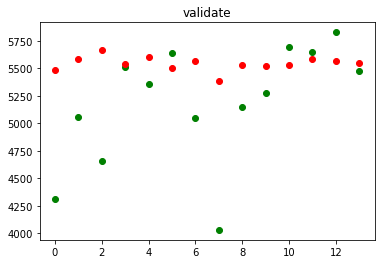

In [33]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

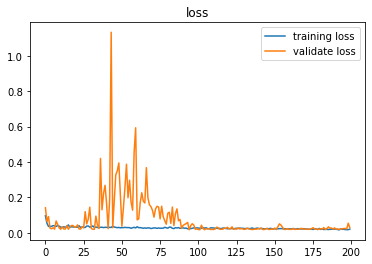

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [35]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

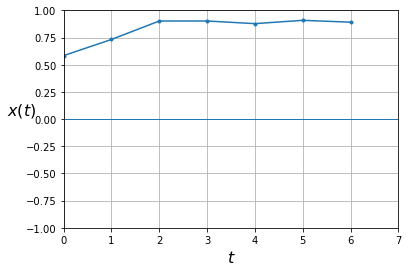

In [36]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [37]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,5486.780273
2020-06-08,5585.627441
2020-06-09,5666.532715
2020-06-10,5534.477051
2020-06-11,5601.048340
2020-06-12,5505.604980
2020-06-13,5568.701660
2020-06-14,5382.058105
2020-06-15,5526.599609
2020-06-16,5519.051758


In [38]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,4308,5486.780273
2020-06-08,5054,5585.627441
2020-06-09,4657,5666.532715
2020-06-10,5512,5534.477051
2020-06-11,5361,5601.048340
2020-06-12,5636,5505.604980
2020-06-13,5046,5568.701660
2020-06-14,4030,5382.058105
2020-06-15,5143,5526.599609
2020-06-16,5272,5519.051758


In [39]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [40]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-25':'2020-5-31']

In [41]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [42]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [43]:
print(trainX1)

[[0.29111427 0.26459807 0.46600848 0.24231315 0.06713682 0.3486601
  0.38730603]
 [0.26459807 0.46600848 0.24231315 0.06713682 0.3486601  0.38730603
  0.40310293]
 [0.46600848 0.24231315 0.06713682 0.3486601  0.38730603 0.40310293
  0.20394921]
 [0.24231315 0.06713682 0.3486601  0.38730603 0.40310293 0.20394921
  0.10267985]
 [0.06713682 0.3486601  0.38730603 0.40310293 0.20394921 0.10267985
  0.25923836]
 [0.3486601  0.38730603 0.40310293 0.20394921 0.10267985 0.25923836
  0.        ]
 [0.38730603 0.40310293 0.20394921 0.10267985 0.25923836 0.
  0.19464034]
 [0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
  0.37517637]
 [0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
  0.3565585 ]
 [0.10267985 0.25923836 0.         0.19464034 0.37517637 0.3565585
  0.53765875]
 [0.25923836 0.         0.19464034 0.37517637 0.3565585  0.53765875
  0.5145275 ]
 [0.         0.19464034 0.37517637 0.3565585  0.53765875 0.5145275
  0.29196054]
 [0.19464034 0.37517637 0.3

In [44]:
print(trainY1)

[0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
 0.3565585  0.53765875 0.5145275  0.29196054 0.16755998 0.44992954
 0.5328632  0.65500706 0.38166434 0.34442878 0.17433006 0.04569817
 0.21438646 0.40056425 0.387024   0.49393517 0.16755998 0.29703808
 0.3080395  0.5531735  0.5655853  0.4823696  0.59689707 0.6578279
 0.2631876  0.12552893 0.5221439  0.59576875 0.62736255 0.5593794
 0.5379408  0.58194643 0.28688294 0.57856137 0.719323   0.60338503
 0.61354023 0.6662906  0.64767283 0.3590973  0.6787024  0.84344155
 0.82877296 0.7478139  0.88942176 0.8279267 ]


In [45]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [46]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0240 - val_loss: 0.0539
Epoch 123/200
52/52 - 0s - loss: 0.0274 - val_loss: 0.0546
Epoch 124/200
52/52 - 0s - loss: 0.0272 - val_loss: 0.0230
Epoch 125/200
52/52 - 0s - loss: 0.0272 - val_loss: 0.0269
Epoch 126/200
52/52 - 0s - loss: 0.0261 - val_loss: 0.0410
Epoch 127/200
52/52 - 0s - loss: 0.0254 - val_loss: 0.0530
Epoch 128/200
52/52 - 0s - loss: 0.0254 - val_loss: 0.0706
Epoch 129/200
52/52 - 0s - loss: 0.0267 - val_loss: 0.0199
Epoch 130/200
52/52 - 0s - loss: 0.0272 - val_loss: 0.0206
Epoch 131/200
52/52 - 0s - loss: 0.0244 - val_loss: 0.0295
Epoch 132/200
52/52 - 0s - loss: 0.0254 - val_loss: 0.0244
Epoch 133/200
52/52 - 0s - loss: 0.0237 - val_loss: 0.0306
Epoch 134/200
52/52 - 0s - loss: 0.0248 - val_loss: 0.0440
Epoch 135/200
52/52 - 0s - loss: 0.0250 - val_loss: 0.0420
Epoch 136/200
52/52 - 0s - loss: 0.0253 - val_loss: 0.0274
Epoch 137/200
52/52 - 0s - loss: 0.0359 - val_loss: 0.0167
Epoch 138/200
52/52 - 0s - loss: 0.0246 - val_loss: 0.0194
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0357 - val_loss: 0.0186
Epoch 44/200
51/51 - 0s - loss: 0.0372 - val_loss: 0.4054
Epoch 45/200
51/51 - 0s - loss: 0.0322 - val_loss: 0.0224
Epoch 46/200
51/51 - 0s - loss: 0.0360 - val_loss: 0.0182
Epoch 47/200
51/51 - 0s - loss: 0.0275 - val_loss: 0.0786
Epoch 48/200
51/51 - 0s - loss: 0.0297 - val_loss: 0.4287
Epoch 49/200
51/51 - 0s - loss: 0.0325 - val_loss: 0.2495
Epoch 50/200
51/51 - 0s - loss: 0.0326 - val_loss: 0.2379
Epoch 51/200
51/51 - 0s - loss: 0.0279 - val_loss: 0.3990
Epoch 52/200
51/51 - 0s - loss: 0.0304 - val_loss: 0.3634
Epoch 53/200
51/51 - 0s - loss: 0.0284 - val_loss: 0.1535
Epoch 54/200
51/51 - 0s - loss: 0.0306 - val_loss: 0.2400
Epoch 55/200
51/51 - 0s - loss: 0.0345 - val_loss: 0.4692
Epoch 56/200
51/51 - 0s - loss: 0.0302 - val_loss: 0.9940
Epoch 57/200
51/51 - 0s - loss: 0.0325 - val_loss: 0.2186
Epoch 58/200
51/51 - 0s - loss: 0.0316 - val_loss: 0.0312
Epoch 59/200
51/51 - 0s - loss: 0.0301 - val_loss: 0.2053
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0220 - val_loss: 0.1329
Epoch 184/200
51/51 - 0s - loss: 0.0258 - val_loss: 0.0286
Epoch 185/200
51/51 - 0s - loss: 0.0237 - val_loss: 0.0447
Epoch 186/200
51/51 - 0s - loss: 0.0228 - val_loss: 0.0759
Epoch 187/200
51/51 - 0s - loss: 0.0239 - val_loss: 0.0232
Epoch 188/200
51/51 - 0s - loss: 0.0228 - val_loss: 0.0392
Epoch 189/200
51/51 - 0s - loss: 0.0239 - val_loss: 0.0216
Epoch 190/200
51/51 - 0s - loss: 0.0275 - val_loss: 0.0283
Epoch 191/200
51/51 - 0s - loss: 0.0238 - val_loss: 0.1650
Epoch 192/200
51/51 - 0s - loss: 0.0236 - val_loss: 0.0594
Epoch 193/200
51/51 - 0s - loss: 0.0228 - val_loss: 0.1207
Epoch 194/200
51/51 - 0s - loss: 0.0249 - val_loss: 0.1114
Epoch 195/200
51/51 - 0s - loss: 0.0259 - val_loss: 0.0422
Epoch 196/200
51/51 - 0s - loss: 0.0227 - val_loss: 0.0799
Epoch 197/200
51/51 - 0s - loss: 0.0221 - val_loss: 0.0839
Epoch 198/200
51/51 - 0s - loss: 0.0231 - val_loss: 0.0830
Epoch 199/200
51/51 - 0s - loss: 0.0227 - val_loss: 0.06

50/50 - 0s - loss: 0.0239 - val_loss: 0.1322
Epoch 105/200
50/50 - 0s - loss: 0.0235 - val_loss: 0.0702
Epoch 106/200
50/50 - 0s - loss: 0.0214 - val_loss: 0.0726
Epoch 107/200
50/50 - 0s - loss: 0.0221 - val_loss: 0.3211
Epoch 108/200
50/50 - 0s - loss: 0.0244 - val_loss: 0.1009
Epoch 109/200
50/50 - 0s - loss: 0.0235 - val_loss: 0.3340
Epoch 110/200
50/50 - 0s - loss: 0.0272 - val_loss: 0.3132
Epoch 111/200
50/50 - 0s - loss: 0.0243 - val_loss: 0.1271
Epoch 112/200
50/50 - 0s - loss: 0.0222 - val_loss: 0.1878
Epoch 113/200
50/50 - 0s - loss: 0.0257 - val_loss: 0.1998
Epoch 114/200
50/50 - 0s - loss: 0.0224 - val_loss: 0.2009
Epoch 115/200
50/50 - 0s - loss: 0.0219 - val_loss: 0.5641
Epoch 116/200
50/50 - 0s - loss: 0.0251 - val_loss: 0.2492
Epoch 117/200
50/50 - 0s - loss: 0.0226 - val_loss: 0.3930
Epoch 118/200
50/50 - 0s - loss: 0.0243 - val_loss: 0.1661
Epoch 119/200
50/50 - 0s - loss: 0.0255 - val_loss: 0.0715
Epoch 120/200
50/50 - 0s - loss: 0.0260 - val_loss: 0.0567
Epoch 121/2

49/49 - 0s - loss: 0.0386 - val_loss: 0.0209
Epoch 25/200
49/49 - 0s - loss: 0.0415 - val_loss: 0.0316
Epoch 26/200
49/49 - 0s - loss: 0.0332 - val_loss: 0.0238
Epoch 27/200
49/49 - 0s - loss: 0.0373 - val_loss: 0.0377
Epoch 28/200
49/49 - 0s - loss: 0.0482 - val_loss: 0.0499
Epoch 29/200
49/49 - 0s - loss: 0.0335 - val_loss: 0.0154
Epoch 30/200
49/49 - 0s - loss: 0.0336 - val_loss: 0.0181
Epoch 31/200
49/49 - 0s - loss: 0.0336 - val_loss: 0.0264
Epoch 32/200
49/49 - 0s - loss: 0.0332 - val_loss: 0.2320
Epoch 33/200
49/49 - 0s - loss: 0.0311 - val_loss: 0.2756
Epoch 34/200
49/49 - 0s - loss: 0.0380 - val_loss: 0.0888
Epoch 35/200
49/49 - 0s - loss: 0.0253 - val_loss: 0.0306
Epoch 36/200
49/49 - 0s - loss: 0.0283 - val_loss: 0.1486
Epoch 37/200
49/49 - 0s - loss: 0.0314 - val_loss: 0.3639
Epoch 38/200
49/49 - 0s - loss: 0.0272 - val_loss: 0.0558
Epoch 39/200
49/49 - 0s - loss: 0.0306 - val_loss: 0.5159
Epoch 40/200
49/49 - 0s - loss: 0.0292 - val_loss: 0.9078
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0223 - val_loss: 0.1082
Epoch 166/200
49/49 - 0s - loss: 0.0230 - val_loss: 0.1804
Epoch 167/200
49/49 - 0s - loss: 0.0194 - val_loss: 0.0917
Epoch 168/200
49/49 - 0s - loss: 0.0208 - val_loss: 0.1805
Epoch 169/200
49/49 - 0s - loss: 0.0194 - val_loss: 0.1635
Epoch 170/200
49/49 - 0s - loss: 0.0196 - val_loss: 0.1608
Epoch 171/200
49/49 - 0s - loss: 0.0245 - val_loss: 0.3358
Epoch 172/200
49/49 - 0s - loss: 0.0206 - val_loss: 0.2945
Epoch 173/200
49/49 - 0s - loss: 0.0215 - val_loss: 0.5124
Epoch 174/200
49/49 - 0s - loss: 0.0222 - val_loss: 0.2352
Epoch 175/200
49/49 - 0s - loss: 0.0188 - val_loss: 0.3040
Epoch 176/200
49/49 - 0s - loss: 0.0224 - val_loss: 0.2334
Epoch 177/200
49/49 - 0s - loss: 0.0203 - val_loss: 0.4573
Epoch 178/200
49/49 - 0s - loss: 0.0236 - val_loss: 0.1134
Epoch 179/200
49/49 - 0s - loss: 0.0219 - val_loss: 0.1898
Epoch 180/200
49/49 - 0s - loss: 0.0199 - val_loss: 0.3367
Epoch 181/200
49/49 - 0s - loss: 0.0207 - val_loss: 0.32

Epoch 86/200
48/48 - 0s - loss: 0.0175 - val_loss: 0.8561
Epoch 87/200
48/48 - 0s - loss: 0.0219 - val_loss: 0.8110
Epoch 88/200
48/48 - 0s - loss: 0.0238 - val_loss: 0.5619
Epoch 89/200
48/48 - 0s - loss: 0.0221 - val_loss: 0.8491
Epoch 90/200
48/48 - 0s - loss: 0.0211 - val_loss: 0.7341
Epoch 91/200
48/48 - 0s - loss: 0.0218 - val_loss: 0.3870
Epoch 92/200
48/48 - 0s - loss: 0.0189 - val_loss: 0.8545
Epoch 93/200
48/48 - 0s - loss: 0.0233 - val_loss: 0.1884
Epoch 94/200
48/48 - 0s - loss: 0.0219 - val_loss: 0.2374
Epoch 95/200
48/48 - 0s - loss: 0.0239 - val_loss: 0.1656
Epoch 96/200
48/48 - 0s - loss: 0.0218 - val_loss: 0.3250
Epoch 97/200
48/48 - 0s - loss: 0.0206 - val_loss: 0.1706
Epoch 98/200
48/48 - 0s - loss: 0.0194 - val_loss: 0.4567
Epoch 99/200
48/48 - 0s - loss: 0.0195 - val_loss: 0.3585
Epoch 100/200
48/48 - 0s - loss: 0.0215 - val_loss: 0.5711
Epoch 101/200
48/48 - 0s - loss: 0.0184 - val_loss: 0.2153
Epoch 102/200
48/48 - 0s - loss: 0.0254 - val_loss: 0.1026
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0458 - val_loss: 0.0635
Epoch 7/200
47/47 - 0s - loss: 0.0422 - val_loss: 0.0359
Epoch 8/200
47/47 - 0s - loss: 0.0402 - val_loss: 0.0274
Epoch 9/200
47/47 - 0s - loss: 0.0420 - val_loss: 0.0308
Epoch 10/200
47/47 - 0s - loss: 0.0448 - val_loss: 0.0304
Epoch 11/200
47/47 - 0s - loss: 0.0433 - val_loss: 0.0289
Epoch 12/200
47/47 - 0s - loss: 0.0516 - val_loss: 0.0281
Epoch 13/200
47/47 - 0s - loss: 0.0410 - val_loss: 0.0428
Epoch 14/200
47/47 - 0s - loss: 0.0364 - val_loss: 0.0293
Epoch 15/200
47/47 - 0s - loss: 0.0446 - val_loss: 0.0494
Epoch 16/200
47/47 - 0s - loss: 0.0383 - val_loss: 0.0337
Epoch 17/200
47/47 - 0s - loss: 0.0430 - val_loss: 0.0607
Epoch 18/200
47/47 - 0s - loss: 0.0335 - val_loss: 0.0429
Epoch 19/200
47/47 - 0s - loss: 0.0406 - val_loss: 0.0397
Epoch 20/200
47/47 - 0s - loss: 0.0359 - val_loss: 0.0327
Epoch 21/200
47/47 - 0s - loss: 0.0404 - val_loss: 0.0446
Epoch 22/200
47/47 - 0s - loss: 0.0410 - val_loss: 0.0348
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0149 - val_loss: 0.0363
Epoch 148/200
47/47 - 0s - loss: 0.0188 - val_loss: 0.0188
Epoch 149/200
47/47 - 0s - loss: 0.0158 - val_loss: 0.0320
Epoch 150/200
47/47 - 0s - loss: 0.0139 - val_loss: 0.0436
Epoch 151/200
47/47 - 0s - loss: 0.0189 - val_loss: 0.0662
Epoch 152/200
47/47 - 0s - loss: 0.0156 - val_loss: 0.0451
Epoch 153/200
47/47 - 0s - loss: 0.0199 - val_loss: 0.0399
Epoch 154/200
47/47 - 0s - loss: 0.0183 - val_loss: 0.0560
Epoch 155/200
47/47 - 0s - loss: 0.0172 - val_loss: 0.0222
Epoch 156/200
47/47 - 0s - loss: 0.0164 - val_loss: 0.0276
Epoch 157/200
47/47 - 0s - loss: 0.0127 - val_loss: 0.0446
Epoch 158/200
47/47 - 0s - loss: 0.0111 - val_loss: 0.0412
Epoch 159/200
47/47 - 0s - loss: 0.0142 - val_loss: 0.0242
Epoch 160/200
47/47 - 0s - loss: 0.0144 - val_loss: 0.0287
Epoch 161/200
47/47 - 0s - loss: 0.0142 - val_loss: 0.0181
Epoch 162/200
47/47 - 0s - loss: 0.0151 - val_loss: 0.0194
Epoch 163/200
47/47 - 0s - loss: 0.0154 - val_loss: 0.02

# Preparamos los datos para el test

In [47]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [48]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [49]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.58608913]
 [0.7250353 ]
 [0.8879719 ]
 [0.7997592 ]
 [0.9572862 ]
 [0.90683675]
 [0.1046585 ]]


# Re-Convertimos los resultados

In [50]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[4986],
       [5137],
       [5314],
       [5218],
       [5389],
       [5334],
       [4464]])

# Visualizamos el pronostico

<AxesSubplot:>

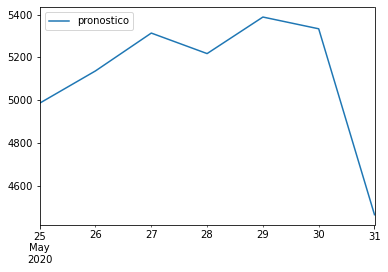

In [51]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [52]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,4688,4986
2020-05-26,5272,5137
2020-05-27,5220,5314
2020-05-28,4933,5218
2020-05-29,5435,5389
2020-05-30,5217,5334
2020-05-31,4351,4464


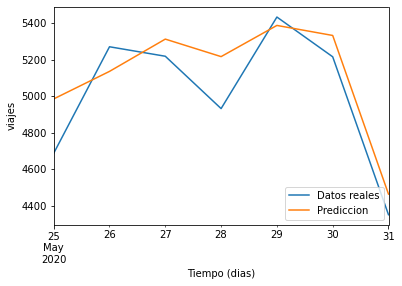

In [53]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [54]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 155.43 MAE
Resultado del test: 32237.71 MSE
Resultado del test: 179.55 RMSE
Resultado del test: 3.51 CVRMSE
Resultado del test: 3.06 MAPE


In [55]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 298.00 MAE
Resultado del test dia 1: 88804.00 MSE
Resultado del test dia 1: 298.00 RMSE
Resultado del test dia 1: 5.98 CVRMSE
Resultado del test dia 1: 5.98 MAPE 

Resultado del test dia 2: 135.00 MAE
Resultado del test dia 2: 18225.00 MSE
Resultado del test dia 2: 135.00 RMSE
Resultado del test dia 2: 2.63 CVRMSE
Resultado del test dia 2: 2.63 MAPE 

Resultado del test dia 3: 94.00 MAE
Resultado del test dia 3: 8836.00 MSE
Resultado del test dia 3: 94.00 RMSE
Resultado del test dia 3: 1.77 CVRMSE
Resultado del test dia 3: 1.77 MAPE 

Resultado del test dia 4: 285.00 MAE
Resultado del test dia 4: 81225.00 MSE
Resultado del test dia 4: 285.00 RMSE
Resultado del test dia 4: 5.46 CVRMSE
Resultado del test dia 4: 5.46 MAPE 

Resultado del test dia 5: 46.00 MAE
Resultado del test dia 5: 2116.00 MSE
Resultado del test dia 5: 46.00 RMSE
Resultado del test dia 5: 0.85 CVRMSE
Resultado del test dia 5: 0.85 MAPE 

Resultado del test dia 6: 117.00 MAE
Resultado del test 